# Example 1. Majority Votting Method
---

### 1. Ensemble error curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.misc import comb

In [2]:
# the binomial error as target class is choosen
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/2.) 
    probs = [comb(n_classifier, k)*(error**k)*((1-error)**(n_classifier-k)) 
             for k in range(int(k_start), n_classifier+1)]
    return sum(probs)

In [3]:
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

In [4]:
error_range = np.arange(0., 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

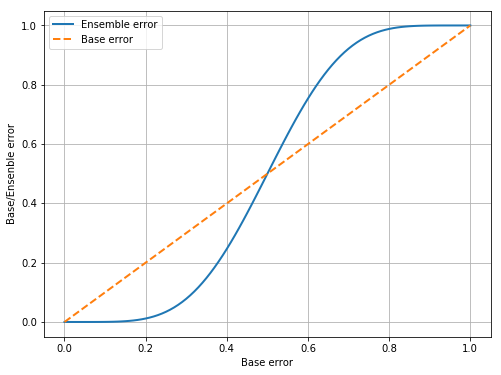

In [5]:
plt.figure(figsize=(8,6))
plt.plot(error_range, ens_errors,  label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, label='Base error',     linewidth=2, linestyle='--')
plt.xlabel('Base error')
plt.ylabel('Base/Ensenble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### 2. Iris example of aggregation
#### 2.1. Import package and data

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import LabelEncoder

In [7]:
le = LabelEncoder()
iris = datasets.load_iris()
X = iris.data[50:, [1,2]]
y = le.fit_transform(iris.target[50:])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

#### 2.2. Train individual model

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.pipeline        import Pipeline
from MajorityVoteClassifier  import *

In [9]:
clf_labels = ['Logistic Regression', 'KNN', 'Decision Tree', 'Majority voting']
clf1 = Pipeline([['sc',  StandardScaler()], 
                 ['clf', LogisticRegression(penalty='l2', C=0.001, random_state=0)]])
clf2 = Pipeline([['sc',  StandardScaler()], 
                 ['clf', KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')]])
clf3 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
# Ensemble above classifiers by Majority Voting Method
clf4 = MajorityVoteClassifier([clf1, clf2, clf3])

In [10]:
for clf, label in zip([clf1, clf2, clf3, clf4], clf_labels):
    score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print 'ROC AUC (10-fold x-val): %.2f (+/- %.2f) [%s]'%(score.mean(), score.std(), label)

ROC AUC (10-fold x-val): 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC (10-fold x-val): 0.93 (+/- 0.10) [KNN]
ROC AUC (10-fold x-val): 0.92 (+/- 0.15) [Decision Tree]
ROC AUC (10-fold x-val): 0.97 (+/- 0.10) [Majority voting]


#### 2.3. ROC plot

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [12]:
clfs   = [clf1, clf2, clf3, clf4]
colors = ['black', 'orange', 'blue', 'green']
lines  = [':', '--', '-.', '-']

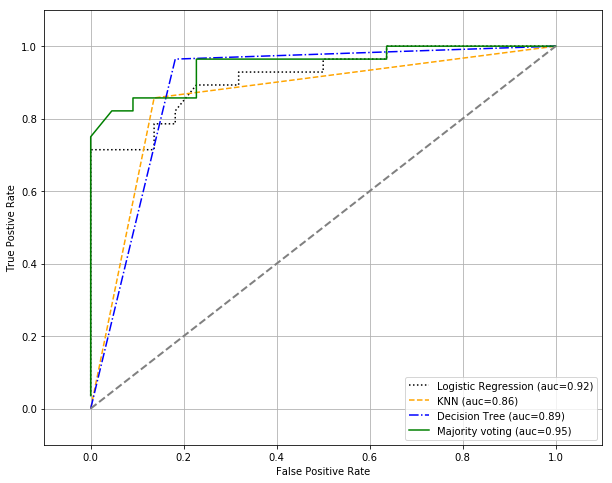

In [13]:
plt.figure(figsize=(10,8))
for clf, label, color, line in zip(clfs, clf_labels, colors, lines):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=color, linestyle=line, label='%s (auc=%.2f)'%(label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.show()

#### 2.4. Visualization of decision regions

In [14]:
from itertools import product

In [15]:
cs = StandardScaler()
X_train_std = cs.fit_transform(X_train)

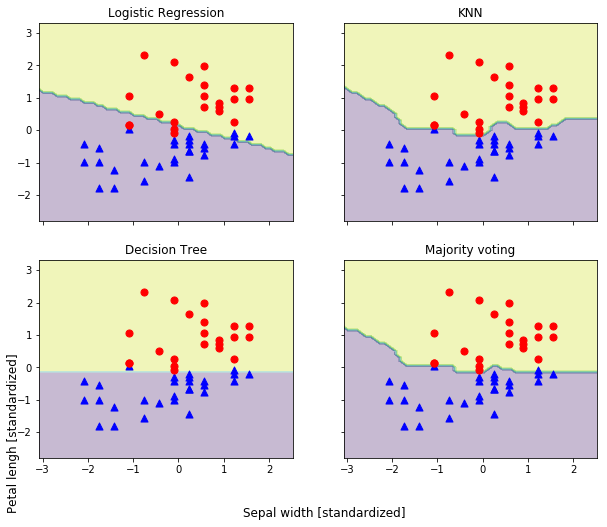

In [23]:
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10,8))
for idx, clf, tt in zip(product([0, 1], [0, 1]), clfs, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter( X_train_std[y_train==0,0], X_train_std[y_train==0,1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter( X_train_std[y_train==1,0], X_train_std[y_train==1,1], c='red',  marker='o', s=50) 
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5,  -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, -4.5, s='Petal lengh [standardized]', ha='left', va='bottom', fontsize=12, rotation=90)
plt.show()